<a href="https://colab.research.google.com/github/SyedHassan20/xgboost-immunogenicity-predictor/blob/main/xgboost-predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Importing packages
#!pip install biopython
from IPython.display import display
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve

from scipy.sparse import hstack, csr_matrix
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


## **Preparing Data**

In [6]:
# Defining the URL
pos_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR9O777xgUf1cNZ025FNXGaPQKGJr9GmcF5UhSIHbvsu0If--9p_PceJdtkLEXrjQ/pub?gid=1174444269&single=true&output=csv"
neg_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT4IyMxpZdDlFTVv__TcfcgTX95-AFsdPtGuRnpoPUf2j4cr0WmVGGz7vqBDsWo4g/pub?gid=1099012796&single=true&output=csv"

# Reading the CSV file from the URL
df_pos = pd.read_csv(pos_url)
df_neg = pd.read_csv(neg_url)



<ipython-input-6-3cb78019ffa8>:7: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neg = pd.read_csv(neg_url)


In [7]:
# Concatenating the datasets (assuming they have the same columns)
df_merged = pd.concat([df_pos, df_neg], ignore_index=True)

# Display the first few rows
display(df_merged.head())

,Name,Source Molecule,Species,Immunogenic
0,AAAAAIFVI,MHC class I related protein A,Homo sapiens,1
1,AAAAALDKKQRNFDKILA,Myosin-7,Homo sapiens,1
2,AAAAKLAGLVFPQPPAPIAV,hypothetical protein Rv3878 - Mycobacterium tu...,Mycobacterium tuberculosis,1
3,AAAGDK,B13 antigen,Trypanosoma cruzi,1
4,AAAGFASKTPANQAISMIDG,Phosphate-binding protein pstS 1 precursor,Mycobacterium tuberculosis,1


In [8]:
# Remove duplicate sequences
data = df_merged.drop_duplicates()

# Check if the label column exists
if "Immunogenic" not in data.columns:
    raise ValueError("The dataset must include an 'Immunogenic' column as labels.")

# Split data into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

## **Feature Engineering**

In [9]:
# Extract Physicochemical Properties using BioPython
def compute_properties(seq):
    """
    Compute selected physicochemical properties for a peptide sequence.
    Returns hydrophobicity, charge at pH 7, molecular weight, and isoelectric point.
    """
    try:
        analysis = ProteinAnalysis(seq)
        hydrophobicity = analysis.gravy()                # Average hydropathy (hydrophobicity)
        charge = analysis.charge_at_pH(7.0)              # Net charge at pH 7
        molecular_weight = analysis.molecular_weight()   # Molecular weight
        isoelectric_point = analysis.isoelectric_point() # Isoelectric point (pI)
    except Exception as e:
        # In case of an error (e.g., invalid sequence), return NaN values
        hydrophobicity, charge, molecular_weight, isoelectric_point = (np.nan, np.nan, np.nan, np.nan)
    return pd.Series([hydrophobicity, charge, molecular_weight, isoelectric_point],
                     index=['hydrophobicity', 'charge', 'molecular_weight', 'isoelectric_point'])

# Apply the function to each sequence in training and test data
train_df[['hydrophobicity', 'charge', 'molecular_weight', 'isoelectric_point']] = train_df['Name'].apply(compute_properties)
test_df[['hydrophobicity', 'charge', 'molecular_weight', 'isoelectric_point']] = test_df['Name'].apply(compute_properties)

In [12]:
# Define and configure the vectorizer
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,3))

# Drop any rows that have NaNs in the 'Name' or numeric columns
train_df = train_df.dropna(subset=['Name', 'Immunogenic',
                                   'hydrophobicity', 'charge',
                                   'molecular_weight', 'isoelectric_point'])
test_df = test_df.dropna(subset=['Name', 'Immunogenic',
                                 'hydrophobicity', 'charge',
                                 'molecular_weight', 'isoelectric_point'])

# Recompute or reuse your feature matrices after dropping rows
X_train_ngrams = vectorizer.fit_transform(train_df['Name'])
X_test_ngrams = vectorizer.transform(test_df['Name'])

# Combine with numeric features again
phys_train = train_df[['hydrophobicity', 'charge',
                       'molecular_weight', 'isoelectric_point']].values
phys_test = test_df[['hydrophobicity', 'charge',
                     'molecular_weight', 'isoelectric_point']].values

# Combine the n-gram features with the physicochemical properties
X_train = hstack([X_train_ngrams, phys_train])
X_test = hstack([X_test_ngrams, phys_test])

# Define labels
y_train = train_df['Immunogenic']
y_test = test_df['Immunogenic']

## **Model Selection & Training**

In [24]:
# Initialize and train a Random Forest Classifier
import time

start_time = time.time()
# Calculate the ratio for the positive class
# Assuming y_train contains 0 for negatives and 1 for positives
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Initialize the model with the computed scale_pos_weight
model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=50,    # Smaller number for faster iteration
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight  # Helps balance the classes
)

# Fit the model
model.fit(X_train, y_train)
end_time = time.time()

print("Training took {:.2f} seconds".format(end_time - start_time))


Training took 27.20 seconds


## **Training & Evaluation**

In [55]:
# Obtain predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Set your desired minimum recall
desired_recall = 0.8

# Since the last element of recalls corresponds to a threshold of 0 and isn't paired with a threshold value,
# we consider recalls[:-1] and thresholds.
candidate_indices = np.where(recalls[:-1] >= desired_recall)[0]

if len(candidate_indices) > 0:
    # From candidates, select the one with the highest precision
    candidate_precisions = precisions[candidate_indices]
    best_index = candidate_indices[np.argmax(candidate_precisions)]
    custom_threshold = thresholds[best_index]
else:
    # Fall back to the default threshold if no candidate meets the desired recall
    custom_threshold = 0.5

print("Selected custom threshold:", custom_threshold)

# Generate predictions with the custom threshold
y_pred_custom = (y_proba >= custom_threshold).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_custom)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_custom, average='binary')

print("Custom Threshold Model Performance:")
print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Selected custom threshold: 0.41765854
Custom Threshold Model Performance:
Accuracy: 0.5920120318688942
ROC-AUC: 0.7356341775074597
Precision: 0.3745915686050497
Recall: 0.8000780849662038
F1-score: 0.5102753849864992


## **Model Interpretation**

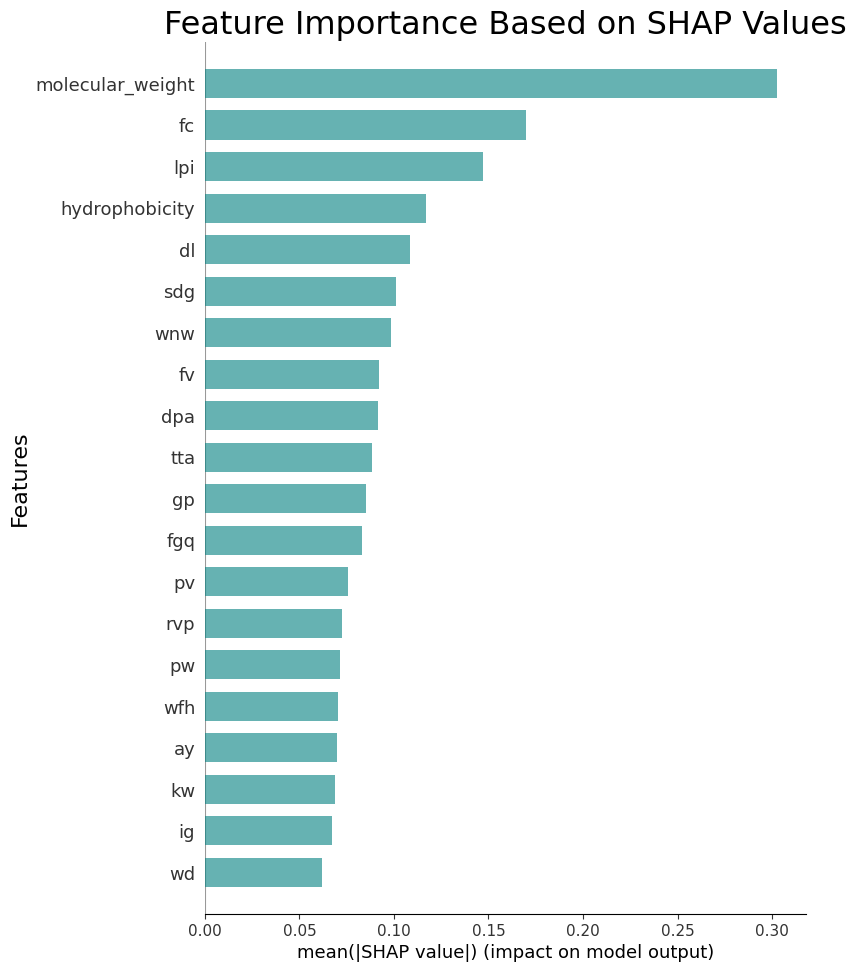

In [63]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Convert your training matrix to CSR format so it supports slicing
X_train_csr = X_train.tocsr()

# Slice the first 1000 rows
X_train_sample_csr = X_train_csr[:1000, :]

# Convert that slice to a dense array (SHAP often requires dense input for tree-based explainers)
X_train_sample_dense = X_train_sample_csr.toarray()

# Compute SHAP values on this subset
shap_values = explainer.shap_values(X_train_sample_dense)

# Handle whether shap_values is a list (older versions / multi-class) or a single array
if isinstance(shap_values, list):
    # For many binary classification scenarios, shap_values is a list of length 2
    # [0] -> SHAP values for the negative class
    # [1] -> SHAP values for the positive class
    shap_values_for_plot = shap_values[1]
else:
    # If shap_values is a single array, use it directly
    shap_values_for_plot = shap_values

# Create a combined list of feature names: n-gram features + physicochemical properties
ngram_features = vectorizer.get_feature_names_out().tolist()
combined_feature_names = ngram_features + [
    'hydrophobicity',
    'charge',
    'molecular_weight',
    'isoelectric_point'
]
# Generate a SHAP summary plot for the positive class (or the single array returned)
shap.summary_plot(
    shap_values_for_plot,
    X_train_sample_dense,
    feature_names=combined_feature_names,
    plot_type="bar",
    show=False  # Prevent auto-display so we can modify the plot
)

# Access the current axes and set all bar patches to teal
ax = plt.gca()
for patch in ax.patches:
    patch.set_facecolor("teal")
    patch.set_alpha(0.6)

# Add a title and label to the y-axis
ax.set_title("Feature Importance Based on SHAP Values", fontsize = 23)
ax.set_ylabel("Features", fontsize = 16)

# (Optional) Add a custom x-axis label
ax.set_xlabel("mean(|SHAP value|) (impact on model output)")

plt.show()

